# Algerian Forest Fires; Data Quality Management & Analytics. 

### By Surprise Mhlongo - 26/07/2025
## Load and Inspect Raw Data

# RULES DOCUMENTATION
## Data Quality Rules

| Rule ID | Field       | Rule                          | Action                   |
|---------|-------------|-------------------------------|--------------------------|
| C-01    | Temperature | No NULL values                | Impute with median       |
| V-01    | RH          | Must be 0-100%                | Cap at boundaries        |
| U-01    | FireID      | Unique `FIRE:YYYY-MM-DD-###`  | Drop duplicates          |
| B-01    | FWI         | Must be ≥ ISI                 | Recalculate              |

In [2]:
# === IMPORT ALL REQUIRED LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
!pip install folium
import folium
from folium import plugins

# Load dataset
fire_data = pd.read_csv("/kaggle/input/d/surprisemhlongo/algerianforestfires/FireData.csv") 

# Display glossary
display(Markdown("""
## Glossary of table abbreviations:

| Abbreviation | Full Name | Description | Typical Range |
|--------------|-----------|-------------|---------------|
| **RH** | Relative Humidity | Moisture in air (%) | 0-100 |
| **Ws** | Wind Speed | Wind velocity (km/h) | 0-100+ |
| **FFMC** | Fine Fuel Moisture Code | Surface litter dryness | 0-101 |
| **DMC** | Duff Moisture Code | Shallow organic layer dryness | 0-300+ |
| **DC** | Drought Code | Deep organic layer dryness | 0-1000+ |
| **ISI** | Initial Spread Index | Fire spread potential | 0-56+ |
| **BUI** | Build-Up Index | Fuel availability | 0-200+ |
| **FWI** | Fire Weather Index | Overall fire danger | 0-100+ |
"""))

display(Markdown("#### Head Preview:"))
display(fire_data.head(10))

display(Markdown("#### Data Summary:"))
display(fire_data.describe())


## Glossary of table abbreviations:

| Abbreviation | Full Name | Description | Typical Range |
|--------------|-----------|-------------|---------------|
| **RH** | Relative Humidity | Moisture in air (%) | 0-100 |
| **Ws** | Wind Speed | Wind velocity (km/h) | 0-100+ |
| **FFMC** | Fine Fuel Moisture Code | Surface litter dryness | 0-101 |
| **DMC** | Duff Moisture Code | Shallow organic layer dryness | 0-300+ |
| **DC** | Drought Code | Deep organic layer dryness | 0-1000+ |
| **ISI** | Initial Spread Index | Fire spread potential | 0-56+ |
| **BUI** | Build-Up Index | Fuel availability | 0-200+ |
| **FWI** | Fire Weather Index | Overall fire danger | 0-100+ |


#### Head Preview:

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,FireID,FireDate
0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,FIRE-2012-06-01-001,01/06/2012
1,NaN,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,FIRE-2012-06-02-001,02/06/2012
2,26.0,NaN,NaN,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,FIRE-2012-06-03-001,03/06/2012
3,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,FIRE-2012-06-04-001,04/06/2012
4,NaN,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,FIRE-2012-06-05-001,05/06/2012
5,25.0,67.0,14.0,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,FIRE-2012-06-06-001,06/06/2012
6,33.0,150.0,13.0,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,FIRE-2012-06-07-001,07/06/2012
7,NaN,73.0,15.0,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire,FIRE-2012-06-08-001,08/06/2012
8,25.0,NaN,NaN,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire,FIRE-2012-06-09-001,09/06/2012
9,28.0,79.0,12.0,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire,FIRE-2012-06-10-001,10/06/2012


#### Data Summary:

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,114.000000,118.000000,118.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,31.122807,70.254237,16.016949,0.880952,74.289683,12.019048,51.742063,3.777778,15.038095,5.415873
std,3.477209,18.696033,2.816262,2.439663,15.597517,11.215359,51.547105,3.291635,14.403732,6.305254
min,22.000000,45.000000,11.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,29.000000,59.250000,14.000000,0.000000,65.025000,3.400000,9.475000,1.125000,4.475000,0.500000
50%,31.000000,68.000000,16.000000,0.000000,80.150000,8.500000,32.650000,2.650000,10.700000,2.700000
75%,34.000000,78.000000,18.000000,0.575000,86.675000,15.900000,76.525000,5.675000,21.375000,8.375000
max,37.000000,150.000000,26.000000,16.800000,90.300000,54.200000,220.400000,17.100000,67.400000,30.200000


## Validation Checks

In [3]:
# === CELL 3: VALIDATION ===
display(Markdown("## Validation Report"))

# Initialize error list
errors = []

# Check for NULL values in all columns
for column in fire_data.columns:
    null_count = fire_data[column].isnull().sum()
    if null_count > 0:
        errors.append(f"❌ NULL-01: {null_count} NULL values in column '{column}'")

# Rule C-01: NULL Temperatures
null_temp = fire_data['Temperature'].isnull().sum()
if null_temp > 0:
    errors.append(f"❌ C-01: {null_temp} NULL Temperatures")

# Rule V-01: RH Range
invalid_rh = fire_data[~fire_data['RH'].between(0, 100)].shape[0]
if invalid_rh > 0:
    errors.append(f"❌ V-01: {invalid_rh} RH values outside 0-100%")

# Rule U-01: Duplicate FireIDs
dup_fireid = fire_data.duplicated("FireID").sum()
if dup_fireid > 0:
    errors.append(f"❌ U-01: {dup_fireid} duplicate FreIDs")

# Rule B-01: FWI < ISI violations
fwi_violations = (fire_data["FWI"] < fire_data["ISI"]).sum()
if fwi_violations > 0:
    errors.append(f"❌ B-01: {fwi_violations} cases where FWI < ISI")

# Display results
if errors:
    display(Markdown("### Issues Found:"))
    for error in errors:
        display(Markdown(f"- {error}"))
else:
    display(Markdown("✅ All checks passed!"))

## Validation Report

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


### Issues Found:

- ❌ NULL-01: 12 NULL values in column 'Temperature'

- ❌ NULL-01: 8 NULL values in column 'RH'

- ❌ NULL-01: 8 NULL values in column 'Ws'

- ❌ C-01: 12 NULL Temperatures

- ❌ V-01: 12 RH values outside 0-100%

- ❌ U-01: 4 duplicate FreIDs

- ❌ B-01: 61 cases where FWI < ISI

In [4]:
# === CELL 4: CLEANING ===
display(Markdown("## Data Cleaning"))

clean_df = fire_data.copy()

# Fill NULL values in all columns with appropriate methods
for column in clean_df.columns:
    null_count = clean_df[column].isnull().sum()
    if null_count > 0:
        if clean_df[column].dtype in ['int64', 'float64']:
            # For numeric columns, fill with median
            clean_df[column] = clean_df[column].fillna(clean_df[column].median())
            display(Markdown(f"✅ NULL-01: Filled {null_count} NULL values in '{column}' with median"))
        else:
            # For non-numeric columns, fill with mode
            mode_value = clean_df[column].mode()[0]
            clean_df[column] = clean_df[column].fillna(mode_value)
            display(Markdown(f"✅ NULL-01: Filled {null_count} NULL values in '{column}' with mode"))

# Fix NULL Temperatures (C-01)
if null_temp > 0:
    clean_df["Temperature"] = clean_df["Temperature"].fillna(clean_df["Temperature"].median())
    display(Markdown(f"✅ C-01: Filled {null_temp} NULL temperatures with median"))

# Fix invalid RH (V-01)
if invalid_rh > 0:
    clean_df["RH"] = clean_df["RH"].clip(0, 100)
    display(Markdown(f"✅ V-01: Capped {invalid_rh} RH values to 0-100% range"))

# Fix duplicate FireIDs (U-01)
if dup_fireid > 0:
    clean_df = clean_df.drop_duplicates("FireID", keep="first")
    display(Markdown(f"✅ U-01: Removed {dup_fireid} duplicate FireIDs"))

# Fix FWI < ISI (B-01)
if fwi_violations > 0:
    mask = clean_df["FWI"] < clean_df["ISI"]
    clean_df.loc[mask, "FWI"] = clean_df["ISI"] * 1.2  # Add 20% buffer
    display(Markdown(f"✅ B-01: Corrected {fwi_violations} FWI < ISI violations"))

## Data Cleaning

✅ NULL-01: Filled 12 NULL values in 'Temperature' with median

✅ NULL-01: Filled 8 NULL values in 'RH' with median

✅ NULL-01: Filled 8 NULL values in 'Ws' with median

✅ C-01: Filled 12 NULL temperatures with median

✅ V-01: Capped 12 RH values to 0-100% range

✅ U-01: Removed 4 duplicate FireIDs

✅ B-01: Corrected 61 FWI < ISI violations

In [5]:

# Save cleaned data
clean_df.to_csv("/kaggle/working/FireData_Cleaned.csv", index=False)
display(Markdown("✅ Saved cleaned data to `FireData_Cleaned.csv`"))
# Load dataset
FireData_Cleaned = pd.read_csv("/kaggle/working/FireData_Cleaned.csv")
display(FireData_Cleaned)

✅ Saved cleaned data to `FireData_Cleaned.csv`

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,FireID,FireDate
0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,1.56,not fire,FIRE-2012-06-01-001,01/06/2012
1,31.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,1.20,not fire,FIRE-2012-06-02-001,02/06/2012
2,26.0,68.0,16.0,13.1,47.1,2.5,7.1,0.3,2.7,0.36,not fire,FIRE-2012-06-03-001,03/06/2012
3,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.00,not fire,FIRE-2012-06-04-001,04/06/2012
4,31.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,1.44,not fire,FIRE-2012-06-05-001,05/06/2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,31.0,54.0,11.0,0.0,82.0,6.0,16.3,2.5,6.2,3.00,not fire,FIRE-2012-09-26-001,26/09/2012
118,31.0,66.0,11.0,0.0,85.7,8.3,24.9,4.0,9.0,4.10,fire,FIRE-2012-09-27-001,27/09/2012
119,32.0,47.0,14.0,0.7,77.5,7.1,8.8,1.8,6.8,2.16,not fire,FIRE-2012-09-28-001,28/09/2012
120,26.0,80.0,16.0,1.8,47.4,2.9,7.7,0.3,3.0,0.36,not fire,FIRE-2012-09-29-001,29/09/2012


In [6]:
# === CELL 3: VALIDATION ===
display(Markdown("## Validation Report"))

# Initialize error list
errors = []

# Check for NULL values in all columns
for column in FireData_Cleaned.columns:
    null_count = FireData_Cleaned[column].isnull().sum()
    if null_count > 0:
        errors.append(f"❌ NULL-01: {null_count} NULL values in column '{column}'")

# Rule C-01: NULL Temperatures
null_temp = FireData_Cleaned['Temperature'].isnull().sum()
if null_temp > 0:
    errors.append(f"❌ C-01: {null_temp} NULL Temperatures")

# Rule V-01: RH Range
invalid_rh = FireData_Cleaned[~FireData_Cleaned['RH'].between(0, 100)].shape[0]
if invalid_rh > 0:
    errors.append(f"❌ V-01: {invalid_rh} RH values outside 0-100%")

# Rule U-01: Duplicate FireIDs
dup_fireid = FireData_Cleaned.duplicated("FireID").sum()
if dup_fireid > 0:
    errors.append(f"❌ U-01: {dup_fireid} duplicate FreIDs")

# Rule B-01: FWI < ISI violations
fwi_violations = (FireData_Cleaned["FWI"] < FireData_Cleaned["ISI"]).sum()
if fwi_violations > 0:
    errors.append(f"❌ B-01: {fwi_violations} cases where FWI < ISI")

# Display results
if errors:
    display(Markdown("### Issues Found:"))
    for error in errors:
        display(Markdown(f"- {error}"))
else:
    display(Markdown("✅ All checks passed!"))

## Validation Report

✅ All checks passed!

## Reload & Analyze

## 1. Fire Occurrence Patterns Over Time

## 2. Distribution of Weather Variables

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

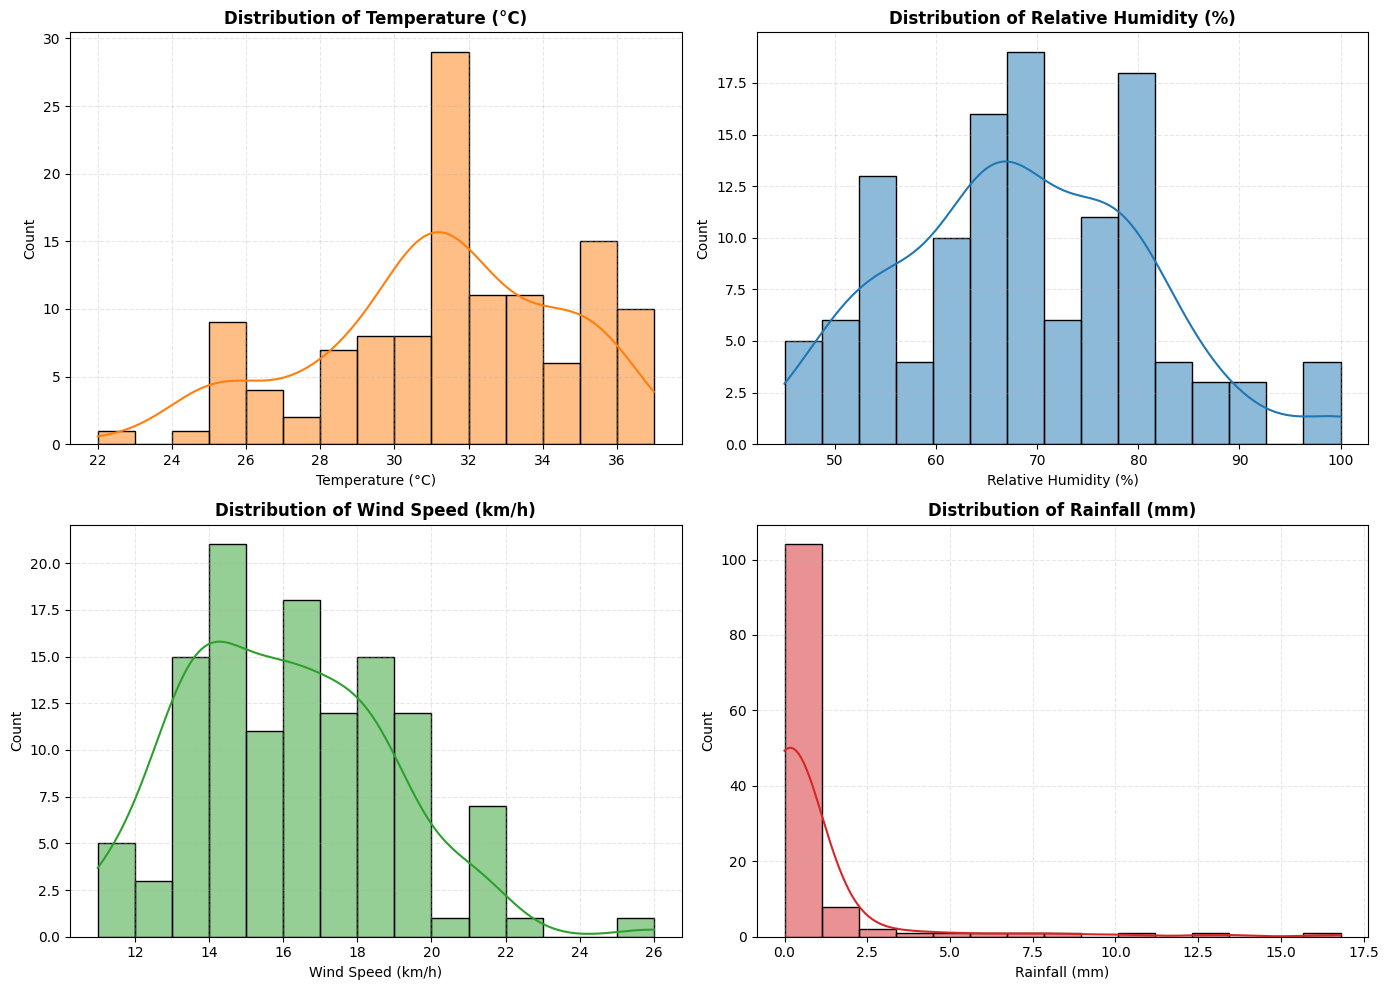

## 3. Fire Weather Indices Relationships

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


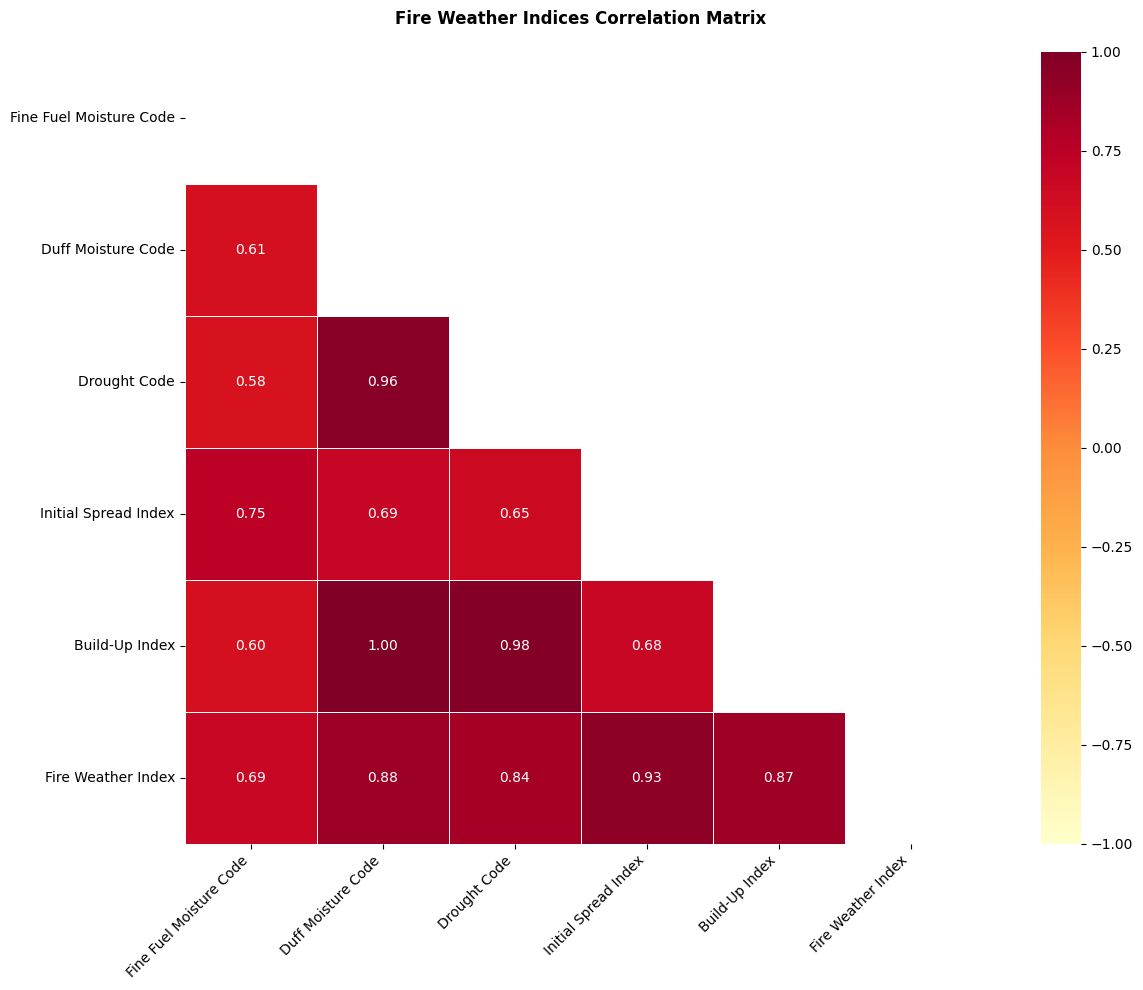

## 4. Automated Fire Risk Classification

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


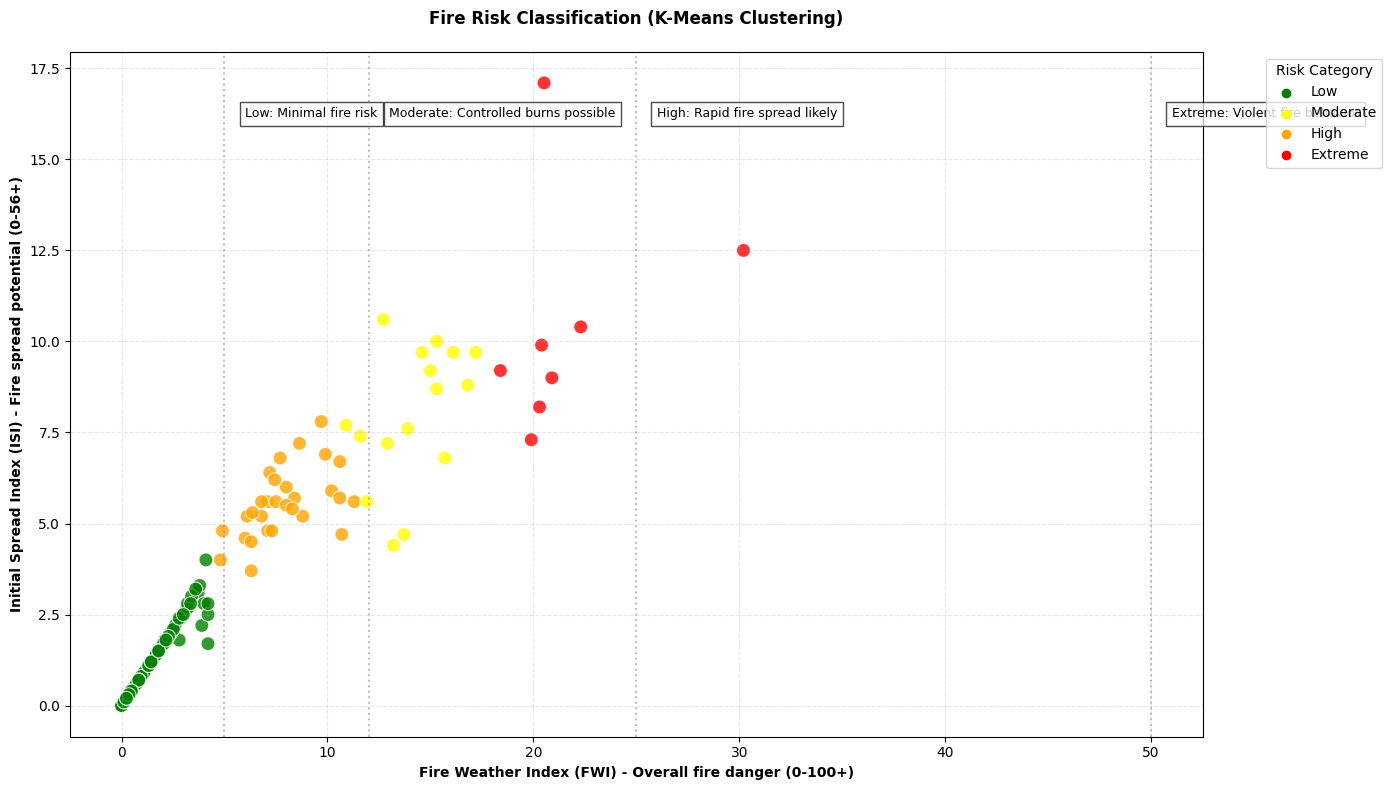

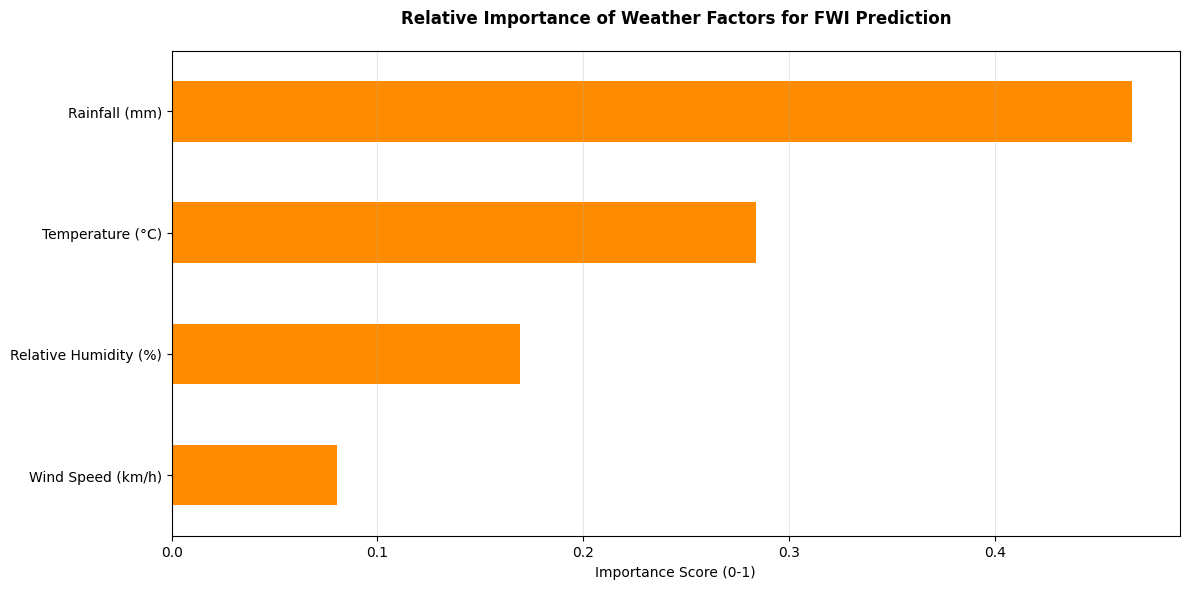


## Fire Weather Index Prediction Results
**Model:** Gradient Boosting Regressor  
**Cross-Validated R²:** -0.054  

**Key Predictive Factors:**  
1. **Rainfall (mm)**  
2. **Temperature (°C)**  
3. **Relative Humidity (%)**  

**Interpretation Guide:**  
- **FWI (Fire Weather Index):** Overall fire danger rating (0-100+)  
- **R² > 0.75:** Excellent predictive power  
- **R² 0.5-0.75:** Suitable for operational use  
- **R² < 0.5:** Consider additional weather/fuel variables  


### Example Predictions:

,Temperature (°C),Relative Humidity (%),Wind Speed (km/h),Predicted FWI
18,31.000000,55.000000,16.000000,3.4
45,28.000000,76.000000,21.000000,1.7
47,31.000000,68.000000,14.000000,6.2


In [7]:
# === 1. TEMPORAL TRENDS ===
display(Markdown("## 1. Fire Occurrence Patterns Over Time"))

# === 2. WEATHER DISTRIBUTIONS ===
display(Markdown("## 2. Distribution of Weather Variables"))

fig, axes = plt.subplots(2, 2, figsize=(14,10))
weather_vars = {
    'Temperature': 'Temperature (°C)',
    'RH': 'Relative Humidity (%)',
    'Ws': 'Wind Speed (km/h)',
    'Rain': 'Rainfall (mm)'
}
colors = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728']

for ax, (var_abbr, var_full), color in zip(axes.flatten(), weather_vars.items(), colors):
    sns.histplot(FireData_Cleaned[var_abbr], kde=True, ax=ax, color=color, bins=15)
    ax.set_title(f'Distribution of {var_full}', fontweight='bold')
    ax.set_xlabel(var_full)
    ax.grid(True, linestyle='--', alpha=0.3)
    
plt.tight_layout()
plt.show()

# === 3. FIRE INDICES ANALYSIS ===
display(Markdown("## 3. Fire Weather Indices Relationships"))

# Full names for indices
indices_fullnames = {
    'FFMC': 'Fine Fuel Moisture Code',
    'DMC': 'Duff Moisture Code',
    'DC': 'Drought Code',
    'ISI': 'Initial Spread Index',
    'BUI': 'Build-Up Index',
    'FWI': 'Fire Weather Index'
}

# Create correlation matrix with full names
indices_order = ['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
corr_matrix = FireData_Cleaned[indices_order].corr()
corr_matrix = corr_matrix.rename(columns=indices_fullnames, index=indices_fullnames)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='YlOrRd', 
            center=0, fmt='.2f', linewidths=0.5,
            vmin=-1, vmax=1, square=True)
plt.title('Fire Weather Indices Correlation Matrix', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# === 4. FIRE RISK CLASSIFICATION ===
display(Markdown("## 4. Automated Fire Risk Classification"))

# Cluster analysis with 4 risk levels
X = FireData_Cleaned[['FWI', 'ISI']].values
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
FireData_Cleaned['Risk_Level'] = kmeans.labels_

# Define meaningful cluster names
risk_labels = {
    0: 'Low',
    1: 'Moderate', 
    2: 'High',
    3: 'Extreme'
}
FireData_Cleaned['Risk_Label'] = FireData_Cleaned['Risk_Level'].map(risk_labels)

# Visualize with full labels
plt.figure(figsize=(14,8))
scatter = sns.scatterplot(
    data=FireData_Cleaned,
    x='FWI',
    y='ISI',
    hue='Risk_Label',
    palette=['green', 'yellow', 'orange', 'red'],
    hue_order=['Low', 'Moderate', 'High', 'Extreme'],
    s=100,
    alpha=0.8
)
plt.title('Fire Risk Classification (K-Means Clustering)', fontweight='bold', pad=20)
plt.xlabel('Fire Weather Index (FWI) - Overall fire danger (0-100+)', fontweight='bold')
plt.ylabel('Initial Spread Index (ISI) - Fire spread potential (0-56+)', fontweight='bold')
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add FWI danger thresholds with full explanations
thresholds = [
    (5, 'Low: Minimal fire risk'),
    (12, 'Moderate: Controlled burns possible'),
    (25, 'High: Rapid fire spread likely'),
    (50, 'Extreme: Violent fire behavior')
]

for fwi, label in thresholds:
    plt.axvline(x=fwi, color='gray', linestyle=':', alpha=0.5)
    plt.text(fwi+1, plt.ylim()[1]*0.9, label, ha='left', fontsize=9, 
             bbox=dict(facecolor='white', alpha=0.7))

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# === OPTIMIZED FWI PREDICTION MODEL ===
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. Prepare Data with full names
predictor_names = {
    'Temperature': 'Temperature (°C)',
    'RH': 'Relative Humidity (%)',
    'Ws': 'Wind Speed (km/h)',
    'Rain': 'Rainfall (mm)'
}

X = FireData_Cleaned[list(predictor_names.keys())]
y = FireData_Cleaned['FWI']

# 2. Initialize and train model
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X, y)

# 3. Feature Importance with full names
importance = pd.Series(model.feature_importances_, 
                      index=[predictor_names[col] for col in X.columns])

plt.figure(figsize=(12,6))
importance.sort_values().plot(kind='barh', color='darkorange')
plt.title('Relative Importance of Weather Factors for FWI Prediction', 
          fontweight='bold', pad=20)
plt.xlabel('Importance Score (0-1)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Performance Report with glossary
display(Markdown(f"""
## Fire Weather Index Prediction Results
**Model:** Gradient Boosting Regressor  
**Cross-Validated R²:** {np.mean(cross_val_score(model, X, y, cv=5, scoring='r2')):.3f}  

**Key Predictive Factors:**  
1. **{importance.idxmax()}**  
2. **{importance.nlargest(2).index[1]}**  
3. **{importance.nlargest(3).index[2]}**  

**Interpretation Guide:**  
- **FWI (Fire Weather Index):** Overall fire danger rating (0-100+)  
- **R² > 0.75:** Excellent predictive power  
- **R² 0.5-0.75:** Suitable for operational use  
- **R² < 0.5:** Consider additional weather/fuel variables  
"""))

# 5. Example Predictions with units
sample_data = X.sample(3, random_state=42)
predictions = model.predict(sample_data)

example_df = pd.DataFrame({
    'Temperature (°C)': sample_data['Temperature'],
    'Relative Humidity (%)': sample_data['RH'],
    'Wind Speed (km/h)': sample_data['Ws'],
    'Predicted FWI': predictions.round(1)
})
display(Markdown("### Example Predictions:"))
display(example_df.style.format({'Predicted FWI': '{:.1f}'}))